## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
LEARNING_RATE = 1e-3
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
EPOCHS = 50
BATCH_SIZE = [128, 256]
MOMENTUM = 0.95
Dropout_EXP = 0.25

In [6]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4,  drp_ratio=Dropout_EXP):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
results = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    for bs in BATCH_SIZE:
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=bs, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l2-%s[%s]" % (str(regulizer_ratio), str(bs))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0721 16:45:59.282230  7048 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 16:45:59.322232  7048 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 16:45:59.378235  7048 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 16:45:59.379235  7048 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 16:45:59.382236  7048 deprecation_wrapper.py:119] From D:\Anaconda3\li

Experiment with Regulizer = 0.010000


W0721 16:45:59.882264  7048 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 16:45:59.992270  7048 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

50000/50000 [==============================] - 29s 572us/step - loss: 1.3431 - acc: 0.5184 - val_loss: 1.3649 - val_acc: 0.5121
Epoch 47/50
50000/50000 [==============================] - 28s 558us/step - loss: 1.3426 - acc: 0.5207 - val_loss: 1.4375 - val_acc: 0.4862
Epoch 48/50
50000/50000 [==============================] - 27s 533us/step - loss: 1.3475 - acc: 0.5189 - val_loss: 1.3933 - val_acc: 0.5029
Epoch 49/50
50000/50000 [==============================] - 29s 581us/step - loss: 1.3407 - acc: 0.5226 - val_loss: 1.4197 - val_acc: 0.4930
Epoch 50/50
50000/50000 [==============================] - 28s 561us/step - loss: 1.3317 - acc: 0.5263 - val_loss: 1.3862 - val_acc: 0.5073
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 414us/step - loss: 1.2917 - acc: 0.5369 - val_loss: 1.3414 - val_acc: 0.5170
Epoch 2/50
50000/50000 [==============================] - 20s 403us/step - loss: 1.2814 - acc: 0.5411 - val_loss: 1.3064 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 30s 608us/step - loss: 2.1117 - acc: 0.2955 - val_loss: 1.6937 - val_acc: 0.3986
Epoch 2/50
50000/50000 [==============================] - 26s 512us/step - loss: 1.7809 - acc: 0.3702 - val_loss: 1.6020 - val_acc: 0.4398s: 1.7839 - ac - ETA: 1s - los
Epoch 3/50
50000/50000 [==============================] - 26s 513us/step - loss: 1.6883 - acc: 0.3991 - val_loss: 1.5758 - val_acc: 0.4481
Epoch 4/50
50000/50000 [==============================] - 25s 504us/step - loss: 1.6284 - acc: 0.4201 - val_loss: 1.5267 - val_acc: 0.4536s: 1.6372 - acc - E - ETA: 1s
Epoch 5/50
50000/50000 [==============================] - 25s 507us/step - loss: 1.5934 - acc: 0.4329 - val_loss: 1.4931 - val_acc: 0.4671
Epoch 6/50
50000/50000 [==============================] - 25s 506us/step - loss: 1.5667 - acc: 0.4392 - val_loss: 1.4792 - val_acc: 0.4751
Epoch 7/50
50000/50000 [==============================] -

Epoch 7/50
50000/50000 [==============================] - 23s 457us/step - loss: 1.2406 - acc: 0.5575 - val_loss: 1.2967 - val_acc: 0.5379
Epoch 8/50
50000/50000 [==============================] - 23s 460us/step - loss: 1.2369 - acc: 0.5550 - val_loss: 1.2971 - val_acc: 0.5356
Epoch 9/50
50000/50000 [==============================] - 23s 458us/step - loss: 1.2325 - acc: 0.5600 - val_loss: 1.2989 - val_acc: 0.5325
Epoch 10/50
50000/50000 [==============================] - 24s 473us/step - loss: 1.2321 - acc: 0.5604 - val_loss: 1.2889 - val_acc: 0.5395
Epoch 11/50
50000/50000 [==============================] - 24s 485us/step - loss: 1.2298 - acc: 0.5584 - val_loss: 1.3374 - val_acc: 0.5252
Epoch 12/50
50000/50000 [==============================] - 24s 471us/step - loss: 1.2244 - acc: 0.5621 - val_loss: 1.3147 - val_acc: 0.5283
Epoch 13/50
50000/50000 [==============================] - 25s 496us/step - loss: 1.2232 - acc: 0.5620 - val_loss: 1.3168 - val_acc: 0.5278
Epoch 14/50
50000/50000

50000/50000 [==============================] - 27s 540us/step - loss: 1.7813 - acc: 0.3665 - val_loss: 1.6400 - val_acc: 0.4105
Epoch 3/50
50000/50000 [==============================] - 26s 519us/step - loss: 1.6891 - acc: 0.3979 - val_loss: 1.5948 - val_acc: 0.4400
Epoch 4/50
50000/50000 [==============================] - 27s 536us/step - loss: 1.6339 - acc: 0.4172 - val_loss: 1.5573 - val_acc: 0.4501
Epoch 5/50
50000/50000 [==============================] - 27s 537us/step - loss: 1.5997 - acc: 0.4300 - val_loss: 1.5173 - val_acc: 0.4594
Epoch 6/50
50000/50000 [==============================] - 27s 542us/step - loss: 1.5798 - acc: 0.4366 - val_loss: 1.4981 - val_acc: 0.4577
Epoch 7/50
50000/50000 [==============================] - 26s 520us/step - loss: 1.5529 - acc: 0.4452 - val_loss: 1.4683 - val_acc: 0.4712
Epoch 8/50
50000/50000 [==============================] - 26s 512us/step - loss: 1.5376 - acc: 0.4482 - val_loss: 1.5119 - val_acc: 0.4542
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 20s 410us/step - loss: 1.2325 - acc: 0.5578 - val_loss: 1.2963 - val_acc: 0.5360
Epoch 8/50
50000/50000 [==============================] - 21s 411us/step - loss: 1.2351 - acc: 0.5615 - val_loss: 1.2960 - val_acc: 0.5323
Epoch 9/50
50000/50000 [==============================] - 21s 413us/step - loss: 1.2324 - acc: 0.5578 - val_loss: 1.3066 - val_acc: 0.5334
Epoch 10/50
50000/50000 [==============================] - 21s 424us/step - loss: 1.2319 - acc: 0.5593 - val_loss: 1.2886 - val_acc: 0.5399
Epoch 11/50
50000/50000 [==============================] - 20s 407us/step - loss: 1.2238 - acc: 0.5634 - val_loss: 1.3050 - val_acc: 0.5313
Epoch 12/50
50000/50000 [==============================] - 20s 407us/step - loss: 1.2252 - acc: 0.5619 - val_loss: 1.3299 - val_acc: 0.5226
Epoch 13/50
50000/50000 [==============================] - 21s 412us/step - loss: 1.2207 - acc: 0.5637 - val_loss: 1.3040 - val_acc: 0.5303
Epoch 14/50
50000/50000 [=========

50000/50000 [==============================] - 27s 545us/step - loss: 1.7778 - acc: 0.3690 - val_loss: 1.6274 - val_acc: 0.4211
Epoch 3/50
50000/50000 [==============================] - 28s 553us/step - loss: 1.6895 - acc: 0.3958 - val_loss: 1.5641 - val_acc: 0.4408
Epoch 4/50
50000/50000 [==============================] - 26s 523us/step - loss: 1.6330 - acc: 0.4146 - val_loss: 1.5253 - val_acc: 0.4581
Epoch 5/50
50000/50000 [==============================] - 25s 506us/step - loss: 1.5971 - acc: 0.4314 - val_loss: 1.5095 - val_acc: 0.4588
Epoch 6/50
50000/50000 [==============================] - 25s 509us/step - loss: 1.5724 - acc: 0.4380 - val_loss: 1.5531 - val_acc: 0.4413
Epoch 7/50
50000/50000 [==============================] - 26s 512us/step - loss: 1.5493 - acc: 0.4474 - val_loss: 1.4946 - val_acc: 0.4712
Epoch 8/50
50000/50000 [==============================] - 26s 524us/step - loss: 1.5352 - acc: 0.4546 - val_loss: 1.4640 - val_acc: 0.4794
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 21s 415us/step - loss: 1.2528 - acc: 0.5510 - val_loss: 1.3072 - val_acc: 0.5353
Epoch 9/50
50000/50000 [==============================] - 21s 415us/step - loss: 1.2513 - acc: 0.5504 - val_loss: 1.3109 - val_acc: 0.5308
Epoch 10/50
50000/50000 [==============================] - 21s 415us/step - loss: 1.2465 - acc: 0.5523 - val_loss: 1.3136 - val_acc: 0.5272
Epoch 11/50
50000/50000 [==============================] - 21s 413us/step - loss: 1.2392 - acc: 0.5558 - val_loss: 1.3128 - val_acc: 0.5353
Epoch 12/50
50000/50000 [==============================] - 21s 413us/step - loss: 1.2465 - acc: 0.5519 - val_loss: 1.3471 - val_acc: 0.5237
Epoch 13/50
50000/50000 [==============================] - 21s 413us/step - loss: 1.2376 - acc: 0.5577 - val_loss: 1.3032 - val_acc: 0.5308
Epoch 14/50
50000/50000 [==============================] - 21s 417us/step - loss: 1.2366 - acc: 0.5580 - val_loss: 1.3183 - val_acc: 0.5311
Epoch 15/50
50000/50000 [========

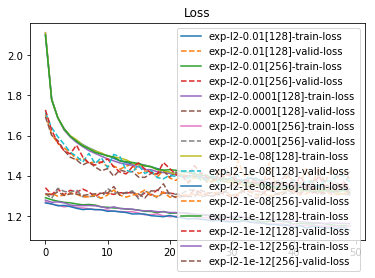

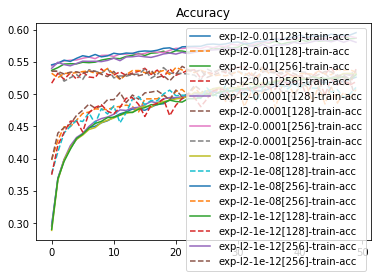

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond + '-train-loss')
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--',label=cond + '-valid-loss')
plt.title("Loss") 
plt.legend()
plt.show()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=cond + '-train-acc')
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond + '-train-acc')
plt.title("Accuracy") 
plt.legend()
plt.show()